<h1>Содержание<span class="tocSkip"></span></h1><div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Preparation

### Imports

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgbm

from sklearn.utils import resample
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

import re
import spacy

import nltk 
from nltk.corpus import stopwords

from tqdm.notebook import tqdm, trange
import warnings

from tqdm.notebook import tqdm
import requests
from pandarallel import pandarallel

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
try: 
    data = pd.read_csv('toxic_comments.csv').drop('Unnamed: 0', axis=1)
except: 
    data = pd.read_csv('/datasets/toxic_comments.csv').drop('Unnamed: 0', axis=1)
data

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159287,""":::::And for the second time of asking, when ...",0
159288,You should be ashamed of yourself \n\nThat is ...,0
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0


In [3]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [4]:
target = data['toxic'].copy()
target.value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

- Соотношение токсчиных комментариев к обычным: 1 : 9

- Всего комментариев ~ 160 тыс.

- Пропуски отсутствуют 

Возьмем 50 тыс. элементов для нашей задачи

In [5]:
SIZE = 50000
alpha = 0.15
beta = 0.5
RND = 123

nltk.download('stopwords', download_dir='/Users/Sergej/Documents')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Sergej/Documents...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Sergej/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### cleaning and lemmatization

In [6]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def lemmatize(text): 
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

def clean(text): 
    text = re.sub(r"[^a-zA-Z']", ' ', text).lower()
    return ' '.join(text.split())

In [7]:
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

data['lemm_text'] = data['text'].progress_apply(clean)
data['lemm_text'] = data['lemm_text'].parallel_apply(lemmatize)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


  0%|          | 0/159292 [00:00<?, ?it/s]

### Word cloud 

In [8]:
df = data.loc[data['toxic']==1].copy()
text_raw = " ".join(df['lemm_text'])
wordcloud = WordCloud().generate(text_raw)

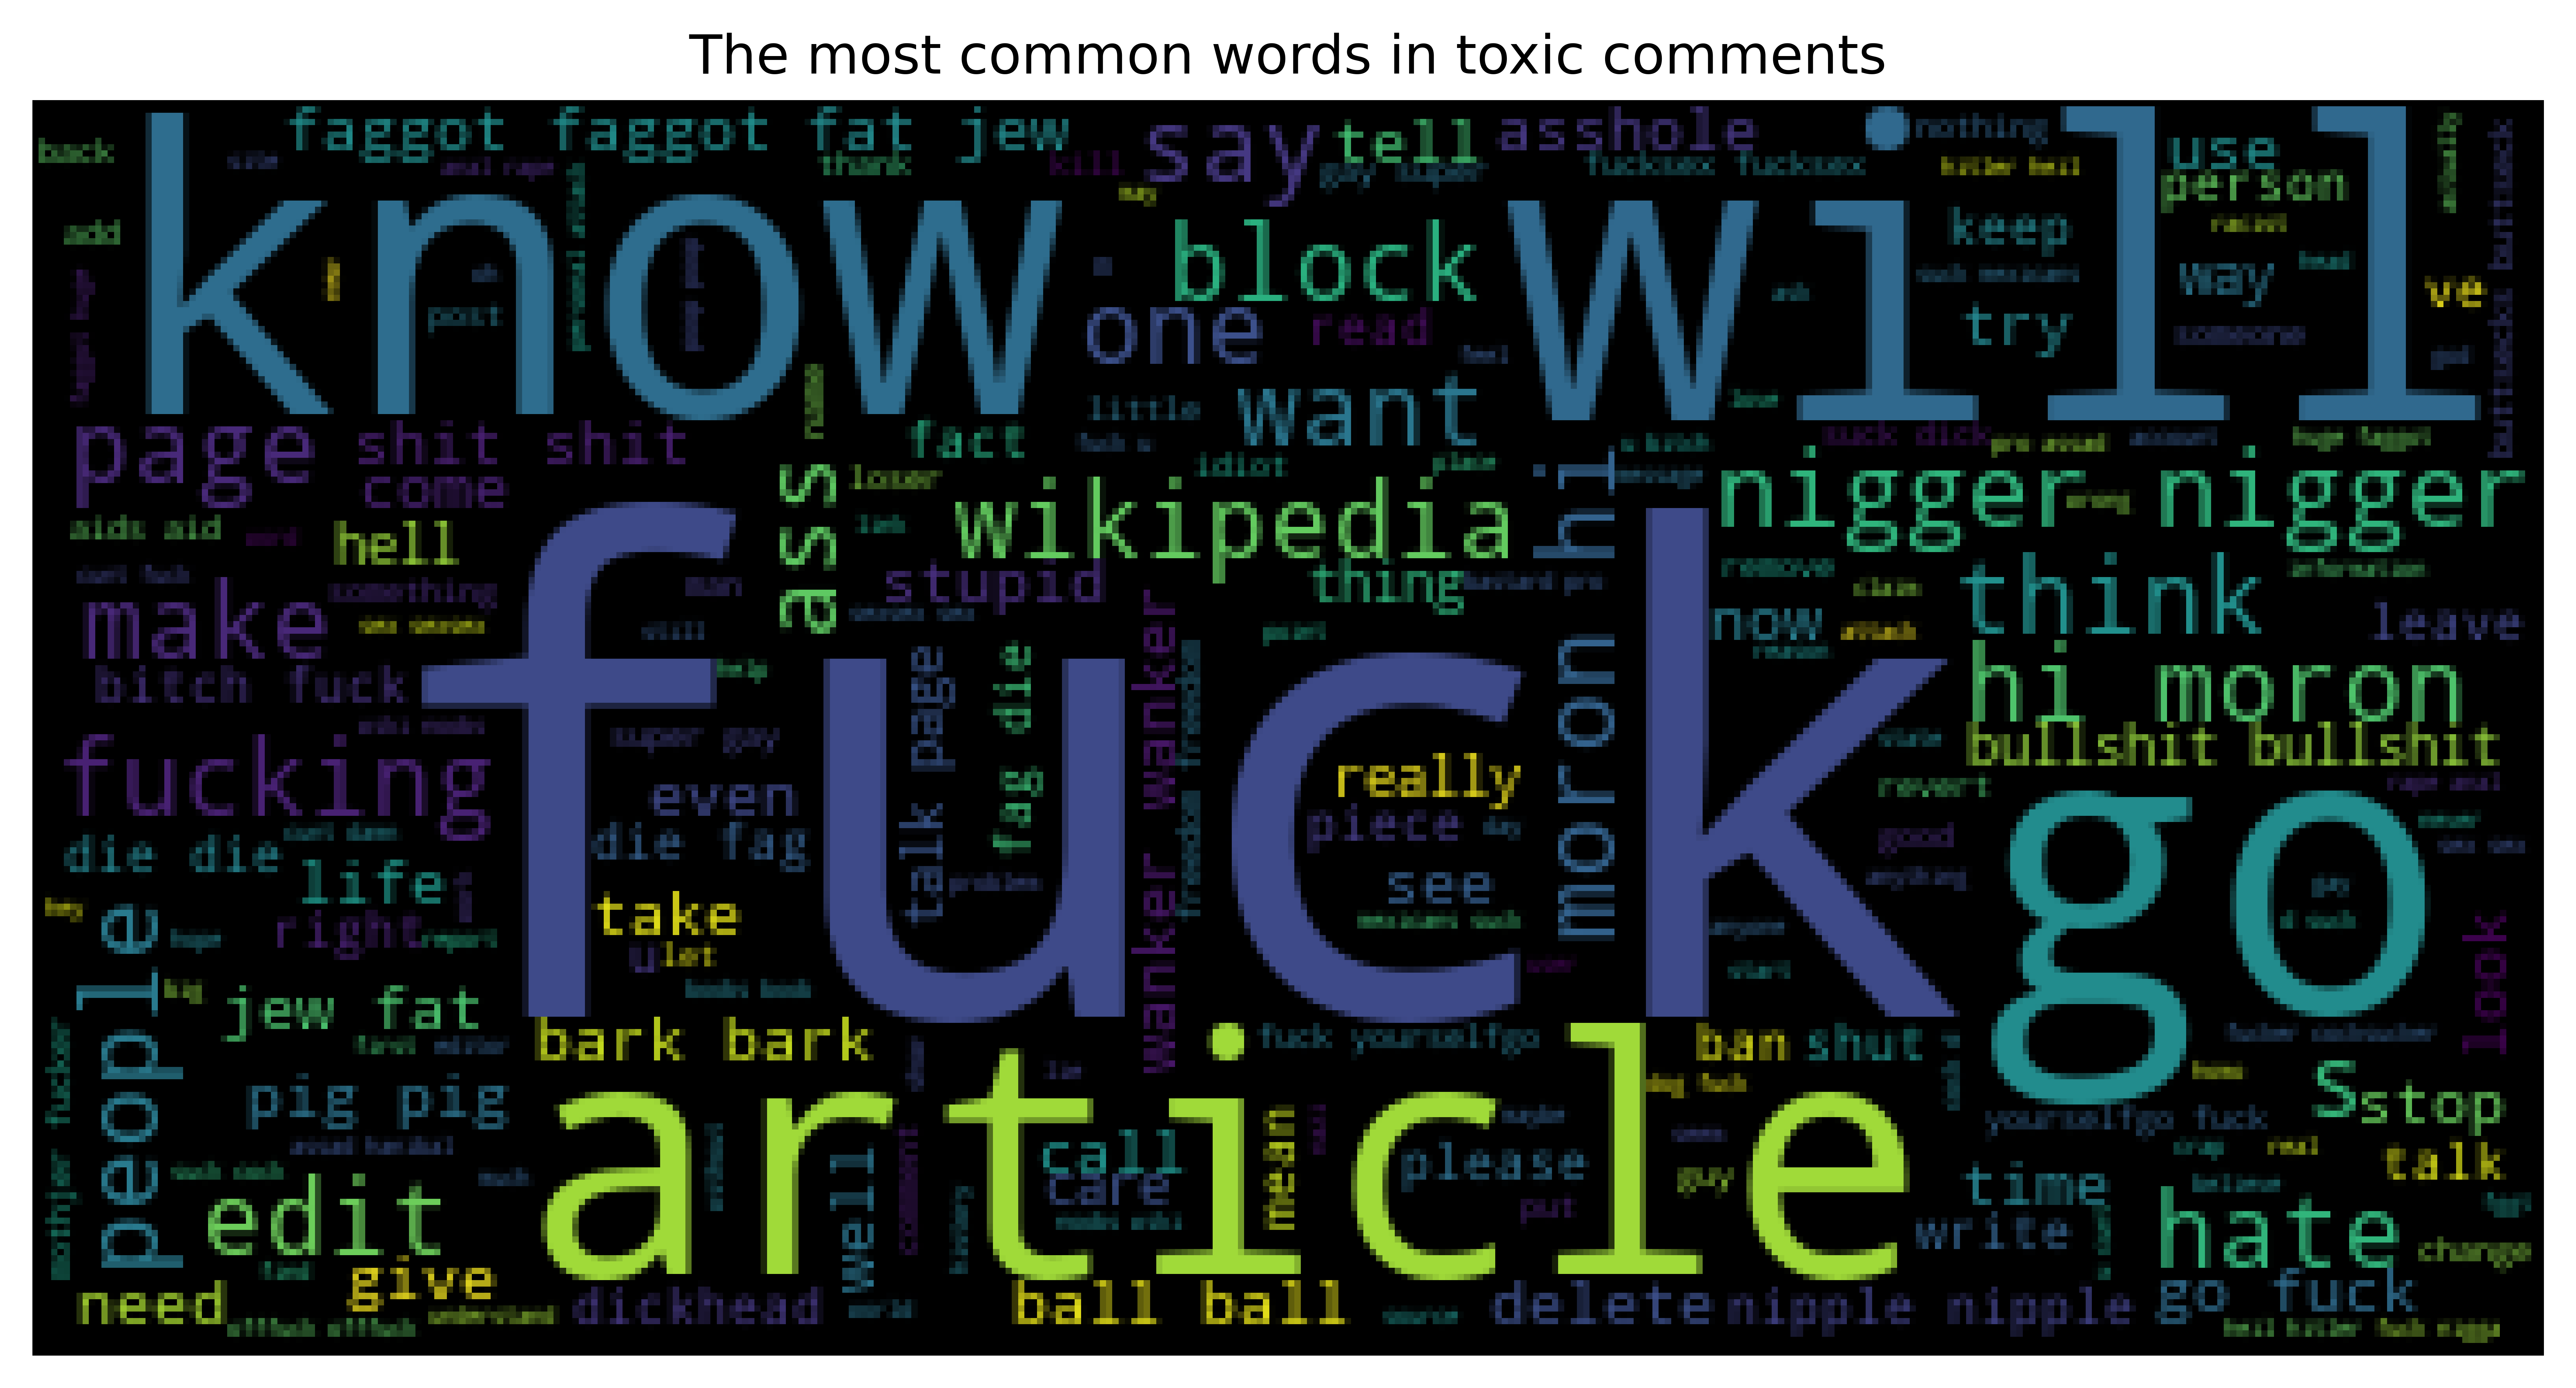

In [9]:
plt.figure(figsize=(10,10), dpi=1000)
plt.imshow(wordcloud)
plt.title('The most common words in toxic comments')
plt.axis('off')
plt.show()

In [10]:
train, test = train_test_split(data, stratify=data['toxic'], random_state=RND, test_size=2*alpha)
test, valid = train_test_split(test, stratify=test['toxic'], random_state=RND, test_size=beta)

### TF - IDF vectorization

In [11]:
vectorizer = TfidfVectorizer(stop_words=stop_words)
X_train, y_train = vectorizer.fit_transform(train['lemm_text'].values), train['toxic']

X_valid, y_valid = vectorizer.transform(valid['lemm_text'].values), valid['toxic']

X_test, y_test = vectorizer.transform(test['lemm_text'].values), test['toxic']

## Learning

### Logistic Regression

In [12]:
model = LogisticRegression(penalty='l1',solver='liblinear', random_state=RND)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
print('Linear_regression F1 score:', round(f1_score(y_pred, y_valid), 3))

Linear_regression F1 score: 0.775


In [13]:
train = train.sample(frac=1/3, random_state=RND)
valid = valid.sample(frac=1/3, random_state=RND)

vectorizer = TfidfVectorizer(stop_words=stop_words)
X_train_t, y_train_t = vectorizer.fit_transform(train['lemm_text'].values), train['toxic']

X_valid_t, y_valid_t = vectorizer.transform(valid['lemm_text'].values), valid['toxic']

X_test_t, y_test_t = vectorizer.transform(test['lemm_text'].values), test['toxic']

### Random Forest

In [14]:
model = RandomForestClassifier(random_state=RND, 
                               n_jobs=-1)

model.fit(X_train_t, y_train_t)
y_pred = model.predict(X_valid_t)
round(f1_score(y_valid_t, y_pred), 3)

0.719

### LightGBM

In [15]:
warnings.filterwarnings("ignore")

In [16]:
num_it = 100
params = {}
params['num_leaves'] = range(10, 211, 20)
params['max_bin'] = range(100, 1001, 100)
params['num_iterations'] = range(100, 301, 20)

In [17]:
best_params = {'num_leaves': 31, 
               'max_bin': 100,
               'num_iterations':60,
               'f1': 0}

#### finding best `num_leaves`

In [18]:
for leaves in tqdm(params['num_leaves'], desc='finding best num_leaves'):
    lgb = lgbm.LGBMClassifier(num_leaves=leaves,
                              num_iterations=best_params['num_iterations'], 
                              max_bin=best_params['max_bin'],
                              random_state=RND)
    lgb.fit(X_train_t, y_train_t)
    y_pred = lgb.predict(X_valid_t)
    f1 = f1_score(y_valid_t, y_pred)
    if f1 > best_params['f1']: 
        best_params['f1'] = f1
        best_params['num_leaves'] = leaves
print('f1_score:', best_params['f1'])
print('num_leaves:', best_params['num_leaves'])

finding best num_leaves:   0%|          | 0/11 [00:00<?, ?it/s]

f1_score: 0.7701232777374909
num_leaves: 70


#### finding best `max_bin`

In [19]:
for bins in tqdm(params['max_bin'], desc='finding best max_bin'):
    lgb = lgbm.LGBMClassifier(num_leaves=best_params['num_leaves'],
                              num_iterations=best_params['num_iterations'], 
                              max_bin=bins,
                              random_state=RND)
    lgb.fit(X_train_t, y_train_t)
    y_pred = lgb.predict(X_valid_t)
    f1 = f1_score(y_valid_t, y_pred)
    if f1 > best_params['f1']: 
        best_params['f1'] = f1
        best_params['max_bin'] = bins
print('f1_score:', best_params['f1'])
print('max_bin:', best_params['max_bin'])

finding best max_bin:   0%|          | 0/10 [00:00<?, ?it/s]

f1_score: 0.772793053545586
max_bin: 1000


#### finding best `num_iterations`

In [20]:
for iterations in tqdm(params['num_iterations'], desc='finding best num_iterations'):
    lgb = lgbm.LGBMClassifier(num_leaves=best_params['num_leaves'],
                              num_iterations=iterations, 
                              max_bin=best_params['max_bin'],
                              random_state=RND)
    lgb.fit(X_train_t, y_train_t)
    y_pred = lgb.predict(X_valid_t)
    f1 = f1_score(y_valid_t, y_pred)
    if f1 > best_params['f1']: 
        best_params['f1'] = f1
        best_params['num_iterations'] = iterations
print('f1_score:', best_params['f1'])
print('iterations:', round(best_params['num_iterations'], 3))

finding best num_iterations:   0%|          | 0/11 [00:00<?, ?it/s]

f1_score: 0.772793053545586
iterations: 60


In [21]:
best_params

{'num_leaves': 70,
 'max_bin': 1000,
 'num_iterations': 60,
 'f1': 0.772793053545586}

### Best model

В сравнении участвовали модели логистической регрессии, случайного леса и модель градиентного бустинга LGBM.

- Модель случайного леса сразу же показала низкий результат (f1: 0.62), даже при отдельной вариации различных параметров f1_score возрастал очень медленно, поэтому эта модель сразу выбыла из сравнения. 

- Модель логистической регрессии показала хороший результат f1 = 0.775 (гиперпараметры: penalty='l1', solver='liblinear') 

- У LGBM f1 = 0.772 ('num_leaves': 70, 'max_bin': 1000,'num_iterations': 60). 

Поэтому берем модели LGBM и LogisticRegression для финальной проверки.

## Testing

LGBM

In [22]:
train_new = pd.concat([train, valid])
X_train_n, y_train_n = vectorizer.transform(train_new['lemm_text'].values), train_new['toxic']


In [23]:
lgb = lgbm.LGBMClassifier(num_leaves=best_params['num_leaves'],
                              num_iterations=best_params['num_iterations'], 
                              max_bin=best_params['max_bin'],
                              random_state=RND)
lgb.fit(X_train_n, y_train_n)
y_pred = lgb.predict(X_test_t)

print('F1 score on test sample:', round(f1_score(y_test_t, y_pred), 3))

F1 score on test sample: 0.752


Logistic Regression

In [24]:
regression = LogisticRegression(penalty='l1', solver='liblinear', random_state=RND)
regression.fit(X_train, y_train)
y_pred = regression.predict(X_test)
print('Linear_regression F1 score:', round(f1_score(y_pred, y_test), 3))

Linear_regression F1 score: 0.783


## Conclusion

Был обработан дасет с комментариями на английском языке, где нужно было определить, негативный отзыв или нет.

- В отзывах присутствовал дисбаланс классов: соотношение положительных комментариев к отрицательным было равно 1:9

- Для приведения текстов к векторному виду были пременены методы: 
    * Очистка и лемматизация
    * TF - IDF векторизация
    
- В сравнении участвовали модели логистической регрессии, случайного леса и модель градиентного бустинга LGBM. Лучше всего проявила себя модель **LGBMClassifier** с гиперпараметрами 
    - 'num_leaves': 70,
    - 'max_bin': 1000,
    - 'num_iterations': 60,
    
- На тестовой выборке модель градиентного бустинга показа результат f1_score = 0.752, логистическая регрессия - 0.783 что подходит под требования задачи